In [2]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_auc_score,roc_curve,classification_report,auc
from sklearn.base import BaseEstimator, TransformerMixin # to create classes
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

# Category encoders
from sklearn.preprocessing import OneHotEncoder


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate


In [3]:
!ls data

sample_submission.csv test.csv              train.csv


In [16]:
# You might have to change this path or the location of this file
data = pd.read_csv('data/train.csv')#.set_index("order_id")

In [17]:
data

,order_id,order_date,amount_usd,payment_method,billing_address_country_code,shipping_address_country_code,avs_code,email_amount_spent_avg_180d,email_orders_count_180d,session_visitor_type,shipping_method_type,card_expiration_date,bin_brand,bin_type,label,suspicious_activity_score
0,181852054,2022-06-02 15:28:13,611.03,payment_method_2,SA,SA,avs_code_8,NaN,NaN,returning,E,05/2025,mastercard,credit,0.0,7.801596
1,181265052,2022-05-21 15:53:20,334.44,payment_method_1,FR,FR,avs_code_1,591.141667,6.0,returning,S,NaN,NaN,NaN,0.0,8.117476
2,149633145,2021-09-30 09:05:06,611.85,payment_method_1,HK,HK,avs_code_1,NaN,NaN,returning,E;E,NaN,NaN,NaN,0.0,6.240885
3,149158895,2021-09-22 15:19:15,198.18,payment_method_2,RU,RU,avs_code_5,473.027368,38.0,returning,E,03/2023,visa,debit,0.0,5.188745
4,169664695,2022-02-18 08:59:32,434.71,payment_method_3,HK,HK,avs_code_5,NaN,NaN,returning,E,NaN,NaN,NaN,0.0,5.738602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195396,149431312,2021-09-26 20:45:39,265.93,payment_method_2,FR,FR,avs_code_5,228.550000,1.0,returning,S,09/2024,visa,debit,0.0,4.827303
195397,163902126,2022-01-03 20:30:02,180.00,payment_method_2,KW,KW,avs_code_8,152.850000,10.0,NaN,E,02/2023,mastercard,credit,0.0,4.127653
195398,153618478,2021-11-09 10:47:54,656.64,payment_method_3,SA,SA,avs_code_8,617.120000,1.0,returning,E,NaN,NaN,NaN,0.0,8.002003
195399,159333719,2021-12-02 15:45:51,179.14,payment_method_2,MC,FR,avs_code_8,NaN,NaN,new,S,10/2024,visa,debit,0.0,4.078712


In [18]:
data=data.drop_duplicates()

In [19]:
data.order_id.nunique()

190266

In [20]:
data.order_id.duplicated().sum()

82

In [21]:
data.duplicated().sum()

0

In [22]:
data.shape

(190348, 16)

In [23]:
data[data.duplicated()]

,order_id,order_date,amount_usd,payment_method,billing_address_country_code,shipping_address_country_code,avs_code,email_amount_spent_avg_180d,email_orders_count_180d,session_visitor_type,shipping_method_type,card_expiration_date,bin_brand,bin_type,label,suspicious_activity_score


In [24]:
data.shipping_method_type.value_counts(dropna=False)

E                                    87580
S                                    51790
E;E                                  19876
S;S                                   8671
E;E;E                                 7406
                                     ...  
S;E;E;E;E;S;S;S;S;S                      1
S;S;S;S;E;E;S;S                          1
S;S;S;S;S;S;S;S;S;S;S;S;S;S;S;S;S        1
E;S;S;E;S                                1
S;S;S;S;E;S;E;S                          1
Name: shipping_method_type, Length: 156, dtype: int64

In [25]:
data.columns

Index(['order_id', 'order_date', 'amount_usd', 'payment_method',
       'billing_address_country_code', 'shipping_address_country_code',
       'avs_code', 'email_amount_spent_avg_180d', 'email_orders_count_180d',
       'session_visitor_type', 'shipping_method_type', 'card_expiration_date',
       'bin_brand', 'bin_type', 'label', 'suspicious_activity_score'],
      dtype='object')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190348 entries, 0 to 195357
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       190348 non-null  int64  
 1   order_date                     190348 non-null  object 
 2   amount_usd                     190348 non-null  float64
 3   payment_method                 189738 non-null  object 
 4   billing_address_country_code   190328 non-null  object 
 5   shipping_address_country_code  190332 non-null  object 
 6   avs_code                       186971 non-null  object 
 7   email_amount_spent_avg_180d    97330 non-null   float64
 8   email_orders_count_180d        96643 non-null   float64
 9   session_visitor_type           155500 non-null  object 
 10  shipping_method_type           190348 non-null  object 
 11  card_expiration_date           131403 non-null  object 
 12  bin_brand                     

In [27]:
data.nunique()

order_id                         190266
order_date                       174799
amount_usd                        83602
payment_method                        8
billing_address_country_code        166
shipping_address_country_code       166
avs_code                             24
email_amount_spent_avg_180d       82105
email_orders_count_180d             665
session_visitor_type                  2
shipping_method_type                156
card_expiration_date                187
bin_brand                            10
bin_type                              3
label                                 2
suspicious_activity_score        190343
dtype: int64

In [28]:
data.shape

(190348, 16)

In [29]:
data.isna().sum()/data.shape[0]

order_id                         0.000000
order_date                       0.000000
amount_usd                       0.000000
payment_method                   0.003205
billing_address_country_code     0.000105
shipping_address_country_code    0.000084
avs_code                         0.017741
email_amount_spent_avg_180d      0.488673
email_orders_count_180d          0.492283
session_visitor_type             0.183075
shipping_method_type             0.000000
card_expiration_date             0.309670
bin_brand                        0.315228
bin_type                         0.317356
label                            0.000026
suspicious_activity_score        0.000000
dtype: float64

<AxesSubplot:>

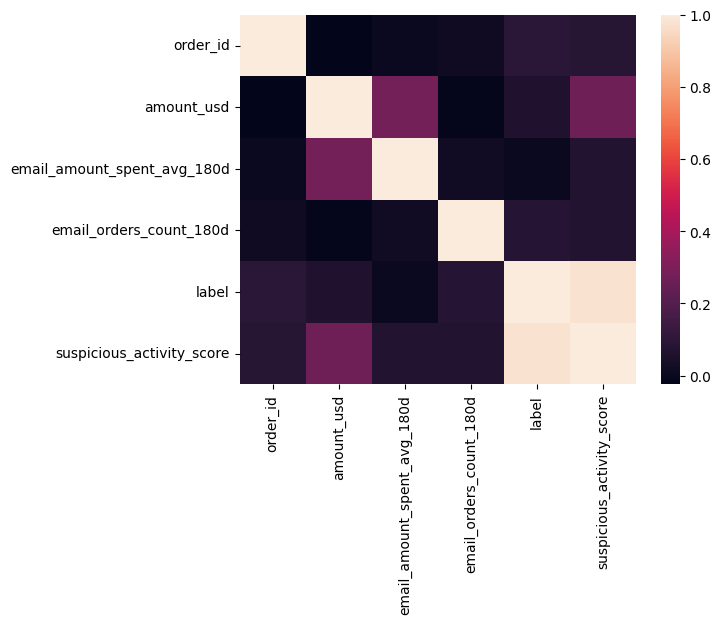

In [30]:
sns.heatmap(data.select_dtypes(include=np.number).corr())

# Transformations for the features

In [103]:
class PaymentMethod(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self

    def transform(self, data):
        X = data.copy()
        columns_to_replace = ['card_expiration_date', 'bin_brand', 'bin_type']
        condition = (X['payment_method'] == 'payment_method_2')

        X.loc[condition, columns_to_replace] = X.loc[condition, columns_to_replace].fillna('missing')

        return X

In [104]:
class SameCountry(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self

    def transform(self, data):
        X = data.copy()
        # remove capitalization
        X["is_same_country"] = (X['billing_address_country_code'] == X['shipping_address_country_code']).astype(int)
        return X

In [105]:
class DateTime(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self

    def transform(self, data):
        X = data.copy()
        # remove capitalization
        # Convert 'order_datetime' to datetime format
        X['order_datetime'] = pd.to_datetime(X['order_date'])
        X['card_expiration_date'] = pd.to_datetime(X['card_expiration_date'])


        #Create Year, Month, Day columns
        X['year'] = X['order_datetime'].dt.year
        X['month'] = X['order_datetime'].dt.month
        X['day'] = X['order_datetime'].dt.day


        # Create 'order_date' and 'order_time' columns
        X['order_date'] = X['order_datetime'].dt.date
        X['order_time'] = X['order_datetime'].dt.time

        # Extract time in seconds from midnight
        X['order_time_seconds'] = (X['order_datetime'] - X['order_datetime'].dt.normalize()).dt.total_seconds()

        # Apply cosine transformation to the time column
        X['time_transformed'] = np.cos(2 * np.pi * X['order_time_seconds'] / 86400)  # 86400 seconds in a day
        return X

In [106]:
class AvgAmountSpentPerOrder180d(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self

    def transform(self, data):
        X = data.copy()
        # remove capitalization
        X['avg_amount_spent_per_order_180d']= (X['email_amount_spent_avg_180d'] / X['email_orders_count_180d'])
        return X

In [107]:
class shippingMethodType(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self

    def transform(self, data):
        X = data.copy()

        X['shipping_method_type'] = X['shipping_method_type'].str.replace('u;n;k;n;o;w;n;_;0', 'Unknown')

        X['n_order_items']=X['shipping_method_type'].str.split(';', expand=True).count(axis=1)

        X['shipping_method_type']=X['shipping_method_type'].str.split(';')

        def count_occurrences(lst, value):
            return lst.count(value)

        # Apply the counting function for each value and create new columns
        # Possble valeus are: 9	C	D	E	N	S	V and unknown
        X['Count_9'] = X['shipping_method_type'].apply(lambda x: count_occurrences(x, '9'))
        X['Count_C'] = X['shipping_method_type'].apply(lambda x: count_occurrences(x, 'C'))
        X['Count_D'] = X['shipping_method_type'].apply(lambda x: count_occurrences(x, 'D'))
        X['Count_E'] = X['shipping_method_type'].apply(lambda x: count_occurrences(x, 'E'))
        X['Count_N'] = X['shipping_method_type'].apply(lambda x: count_occurrences(x, 'N'))
        X['Count_V'] = X['shipping_method_type'].apply(lambda x: count_occurrences(x, 'V'))
        X['Count_unknown'] = X['shipping_method_type'].apply(lambda x: count_occurrences(x, 'Unknown'))

        X['shipping_method_type']=X['shipping_method_type'].apply(lambda x: ','.join(map(str, x)))
        # this converts the list into a string again (but now cleaned)

        df_dummies = X['shipping_method_type'].str.get_dummies(',')

        X = pd.concat([X, df_dummies], axis=1)

        return X

In [108]:
class Duplicates(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X = X.drop_duplicates()
        return X

In [168]:
num_cols = [
    'amount_usd',
    'email_amount_spent_avg_180d',
    'email_orders_count_180d',
    'avg_amount_spent_per_order_180d', #new column
    'time_transformed', #new column
    'n_order_items', #new column
]

categorical_columns=['payment_method',
                     'billing_address_country_code',
                     'shipping_address_country_code',
                     'avs_code',
                     'session_visitor_type',
                     'bin_brand',
                     'bin_type']


num_transformer = Pipeline(steps=[
    ('fillna', SimpleImputer(strategy='constant', fill_value=0)),
    ('robust_scaler', RobustScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('OHE', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])



preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_cols),
        ('cat_transformer', cat_transformer, categorical_columns),
        ('num_transformer', num_transformer, num_cols)
    ]
)


In [169]:
model_rf = RandomForestClassifier(n_estimators=100,
                                  max_depth=5,
                                  min_samples_leaf=5,
                                  class_weight='balanced')


In [170]:

pipeline = Pipeline([
    ("remove_duplicates", Duplicates()),
    ("new_column_same_country", SameCountry()),
    ("new_column_AvgAmountSpentPerOrder180d", AvgAmountSpentPerOrder180d()),
    ("new_column_time_transformed", DateTime()),
    ("new_column_shippingMethod", shippingMethodType()),
    ("Payment_Method_Transformed", PaymentMethod()),
    ("preprocessor", preprocessor),
    ('model', model_rf)
])

# y = label

In [31]:
data.label.value_counts(normalize=True)

0.0    0.907845
1.0    0.092155
Name: label, dtype: float64

In [114]:
#data.suspicious_activity_score.hist()

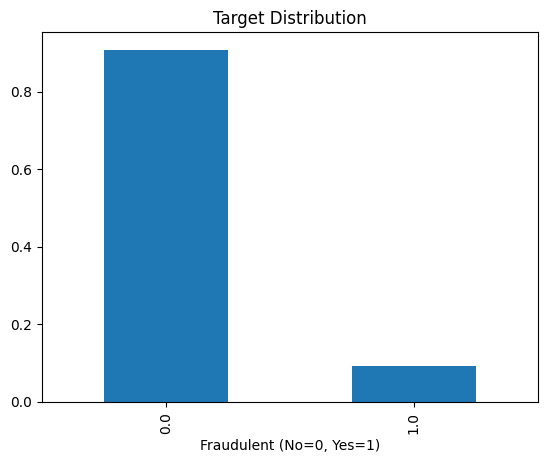

In [33]:
# Checking if the dataset is imbalanced
data["label"].value_counts(normalize=True).plot(kind="bar")
plt.title('Target Distribution')
plt.xlabel("Fraudulent (No=0, Yes=1)");

In [34]:
data.shipping_method_type.value_counts(normalize=True)

E                                    0.460105
S                                    0.272081
E;E                                  0.104419
S;S                                  0.045553
E;E;E                                0.038908
                                       ...   
S;E;E;E;E;S;S;S;S;S                  0.000005
S;S;S;S;E;E;S;S                      0.000005
S;S;S;S;S;S;S;S;S;S;S;S;S;S;S;S;S    0.000005
E;S;S;E;S                            0.000005
S;S;S;S;E;S;E;S                      0.000005
Name: shipping_method_type, Length: 156, dtype: float64

# Rndom Forest baseline

In [167]:
data

,order_id,order_date,amount_usd,payment_method,billing_address_country_code,shipping_address_country_code,avs_code,email_amount_spent_avg_180d,email_orders_count_180d,session_visitor_type,shipping_method_type,card_expiration_date,bin_brand,bin_type,label,suspicious_activity_score
0,181852054,2022-06-02 15:28:13,611.03,payment_method_2,SA,SA,avs_code_8,NaN,NaN,returning,E,05/2025,mastercard,credit,0.0,7.801596
1,181265052,2022-05-21 15:53:20,334.44,payment_method_1,FR,FR,avs_code_1,591.141667,6.0,returning,S,NaN,NaN,NaN,0.0,8.117476
2,149633145,2021-09-30 09:05:06,611.85,payment_method_1,HK,HK,avs_code_1,NaN,NaN,returning,E;E,NaN,NaN,NaN,0.0,6.240885
3,149158895,2021-09-22 15:19:15,198.18,payment_method_2,RU,RU,avs_code_5,473.027368,38.0,returning,E,03/2023,visa,debit,0.0,5.188745
4,169664695,2022-02-18 08:59:32,434.71,payment_method_3,HK,HK,avs_code_5,NaN,NaN,returning,E,NaN,NaN,NaN,0.0,5.738602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195353,167149142,2022-03-01 13:19:06,726.69,payment_method_2,GB,GB,avs_code_4,NaN,NaN,returning,S,11/2026,mastercard,credit,0.0,11.782501
195354,165263810,2022-01-16 19:22:01,86.15,payment_method_2,GB,GB,avs_code_3,NaN,NaN,returning,S,05/2025,visa,debit,0.0,3.927349
195355,173236621,2022-03-26 11:27:15,911.78,payment_method_2,CH,CH,avs_code_6,NaN,NaN,returning,E,02/2025,mastercard,credit,0.0,11.589668
195356,180836679,2022-05-26 20:38:21,768.00,payment_method_2,US,US,avs_code_8,NaN,NaN,NaN,E,03/2025,visa,credit,1.0,57.867662


In [171]:
X = data.drop(columns=['label', 'suspicious_activity_score'])
y = data['label']

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3)

In [173]:
X_train.head()

,order_id,order_date,amount_usd,payment_method,billing_address_country_code,shipping_address_country_code,avs_code,email_amount_spent_avg_180d,email_orders_count_180d,session_visitor_type,shipping_method_type,card_expiration_date,bin_brand,bin_type
112013,149271370,2021-09-24 02:22:04,197.530000,payment_method_3,RU,RU,avs_code_5,NaN,NaN,returning,E,NaN,NaN,NaN
37946,171598073,2022-03-13 13:16:10,511.310000,payment_method_2,KR,KR,avs_code_6,780.03,5.0,returning,E;E;E,06/2024,mastercard,credit
183361,188070888,2022-05-31 15:07:55,663.855714,payment_method_2,BR,BR,avs_code_4,NaN,NaN,returning,E,10/2025,visa,credit
50768,188404475,2022-07-19 16:57:25,518.230000,payment_method_2,TW,TW,avs_code_5,NaN,NaN,returning,E,09/2022,visa,credit
113615,172999962,2022-04-01 12:38:44,41.730000,payment_method_2,GB,GB,avs_code_13,NaN,NaN,NaN,N,04/2024,amex,credit


In [174]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('remove_duplicates', Duplicates()),
                ('new_column_same_country', SameCountry()),
                ('new_column_AvgAmountSpentPerOrder180d',
                 AvgAmountSpentPerOrder180d()),
                ('new_column_time_transformed', DateTime()),
                ('new_column_shippingMethod', shippingMethodType()),
                ('Payment_Method_Transformed', PaymentMethod()),
                ('preprocessor',
                 ColumnTransformer(transformer...
                                                 ('num_transformer',
                                                  Pipeline(steps=[('fillna',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['amount_usd',
                                                   'email_amount_spent_avg_180d',
                                                   'email_orders_count_180d',
                                                   'avg_amount_spent_per_order_180d',
                                                   'time_transformed',
                                                   'n_order_items'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=5))])

In [175]:
cv_results = cross_validate(pipeline, X_train, y_train, scoring = ['roc_auc'], cv=5)
#['accuracy', 'f1', 'roc_auc','recall','precision', 'f1_macro']

In [176]:
cv_results

{'fit_time': array([146.43497491, 145.16392779, 161.1237812 ,  62.54116988,
        106.18001699]),
 'score_time': array([5.8000319 , 9.2318902 , 7.97697091, 6.00857115, 8.6855278 ]),
 'test_roc_auc': array([0.89584821, 0.8991369 , 0.89816463, 0.89932857, 0.89745648])}

In [179]:
cv_results['test_roc_auc'].mean()

0.8979869559154776

In [180]:
y_pred = pipeline.predict(X_test)

In [181]:
correct_predictions = (y_pred == y_test).sum()
print(f"Number of correct predictions: {correct_predictions} \n Percentage: {correct_predictions/y_test.shape[0]}")


Number of correct predictions: 41135 
 Percentage: 0.7203649545558026


Score: 0.81


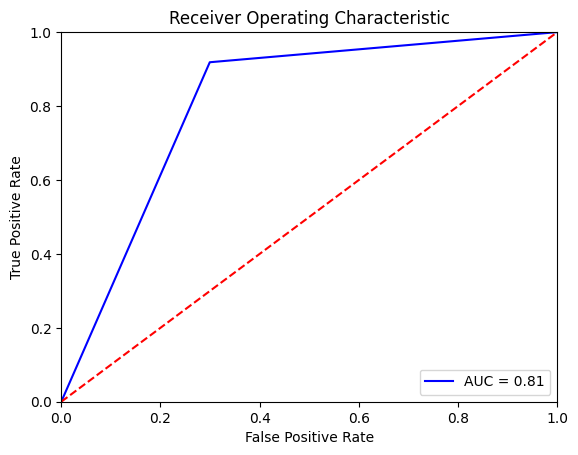

In [182]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("Score: "+ str(round(roc_auc,3)))
plt.show()

# Plots

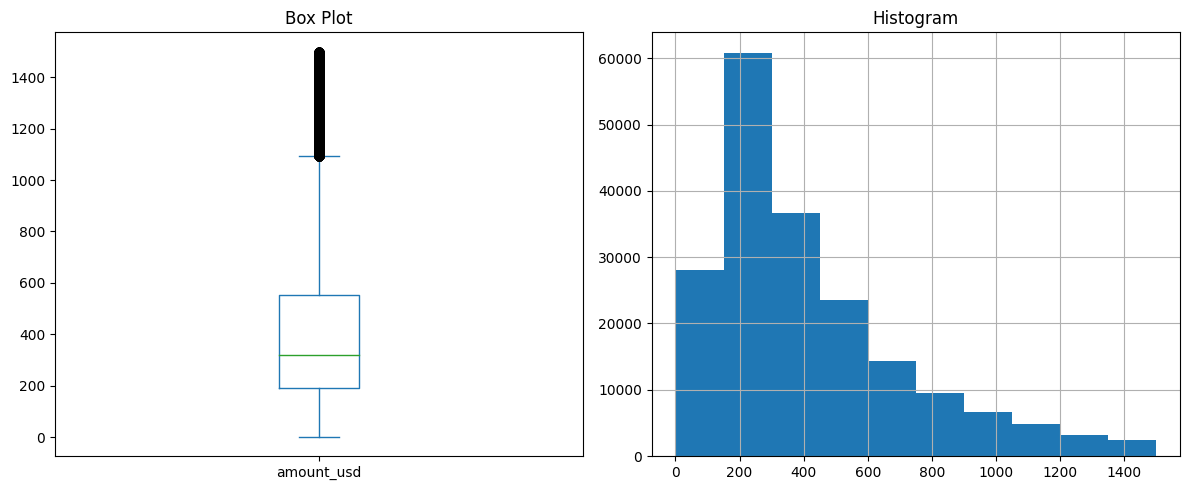

In [38]:
# Create a figure and axis for the plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the box plot on the first axis
data.amount_usd.plot(kind='box', ax=axs[0])
axs[0].set_title('Box Plot')

# Plot the histogram on the second axis
data.amount_usd.hist(ax=axs[1])
axs[1].set_title('Histogram')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

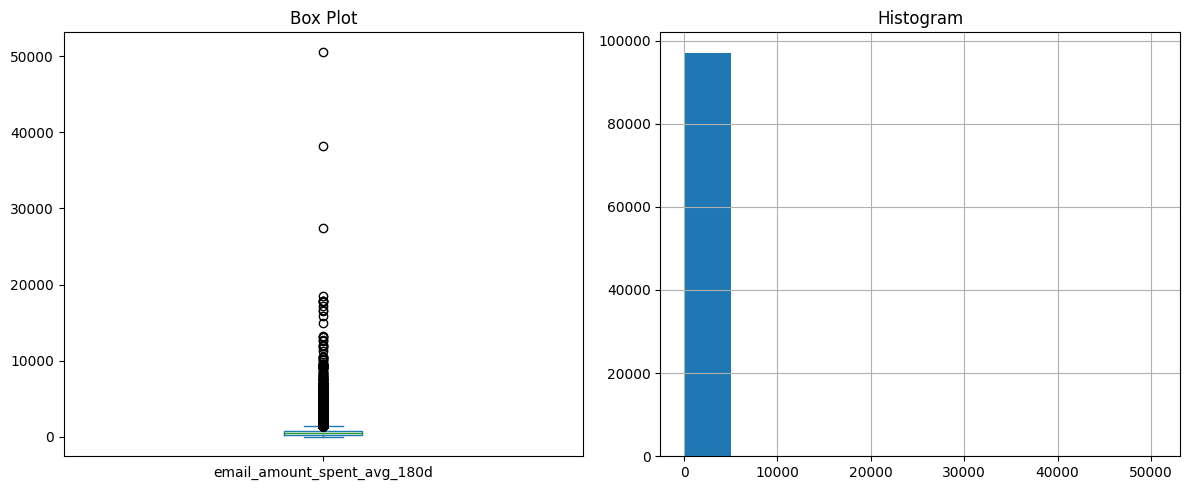

In [39]:
# Create a figure and axis for the plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the box plot on the first axis
data.email_amount_spent_avg_180d.plot(kind='box', ax=axs[0])
axs[0].set_title('Box Plot')

# Plot the histogram on the second axis
data.email_amount_spent_avg_180d.hist(ax=axs[1])
axs[1].set_title('Histogram')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [40]:
data.email_amount_spent_avg_180d.describe()

count    97330.000000
mean       601.481166
std        613.035292
min          1.480000
25%        290.040000
50%        459.951591
75%        729.676012
max      50585.300000
Name: email_amount_spent_avg_180d, dtype: float64

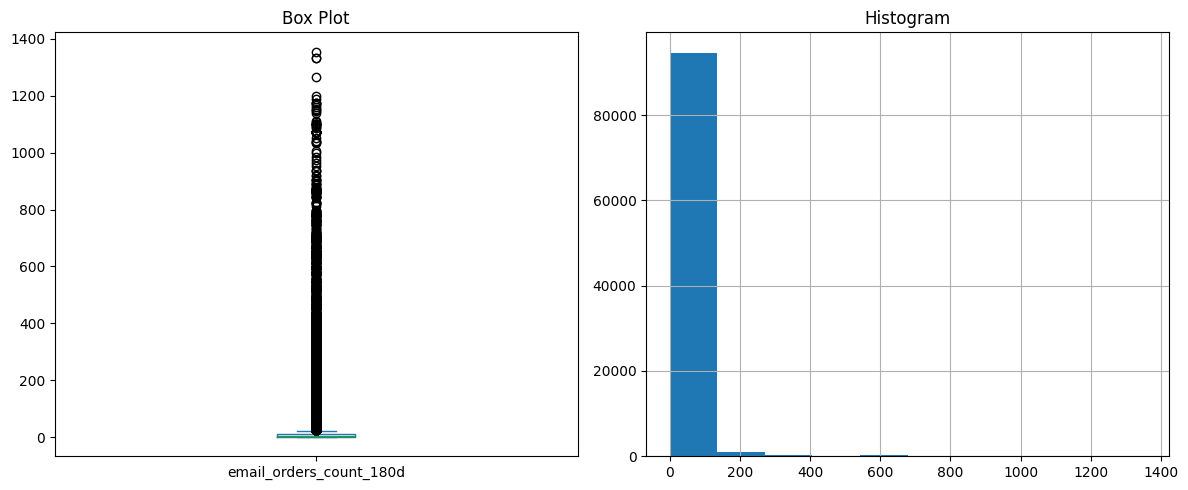

In [41]:
# Create a figure and axis for the plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the box plot on the first axis
data.email_orders_count_180d.plot(kind='box', ax=axs[0])
axs[0].set_title('Box Plot')

# Plot the histogram on the second axis
data.email_orders_count_180d.hist(ax=axs[1])
axs[1].set_title('Histogram')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [42]:
data.email_orders_count_180d.describe()

count    96643.000000
mean        16.579369
std         59.206061
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max       1355.000000
Name: email_orders_count_180d, dtype: float64

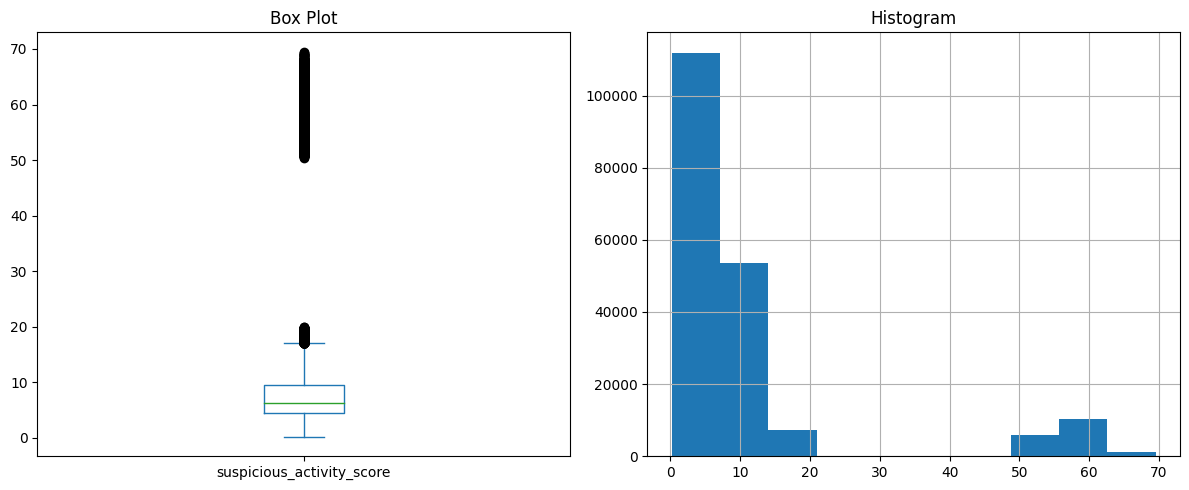

In [43]:
# Create a figure and axis for the plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the box plot on the first axis
data.suspicious_activity_score.plot(kind='box', ax=axs[0])
axs[0].set_title('Box Plot')

# Plot the histogram on the second axis
data.suspicious_activity_score.hist(ax=axs[1])
axs[1].set_title('Histogram')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [44]:
data.suspicious_activity_score.describe()

count    190348.000000
mean         11.273443
std          15.030916
min           0.177196
25%           4.414114
50%           6.325071
75%           9.487706
max          69.523928
Name: suspicious_activity_score, dtype: float64

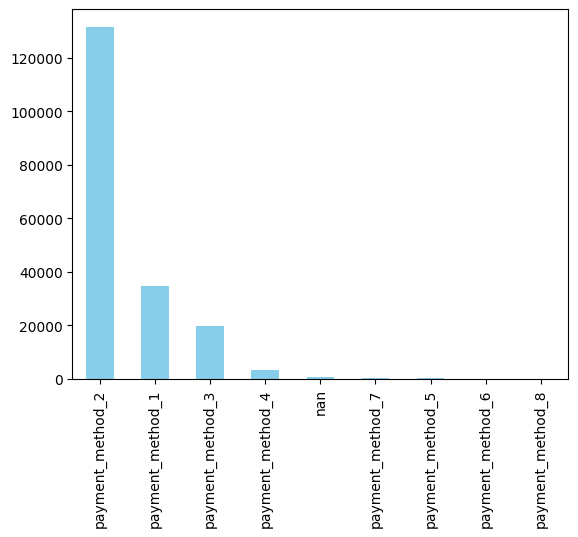

In [45]:
data.payment_method.value_counts(dropna=False).plot(kind='bar', color='skyblue');

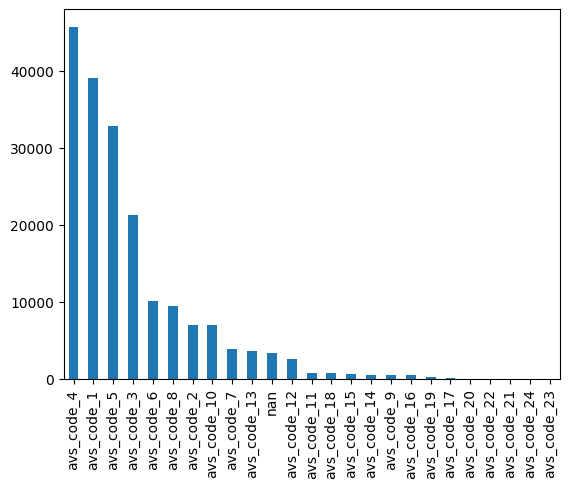

In [46]:
data.avs_code.value_counts(dropna=False).plot(kind='bar');

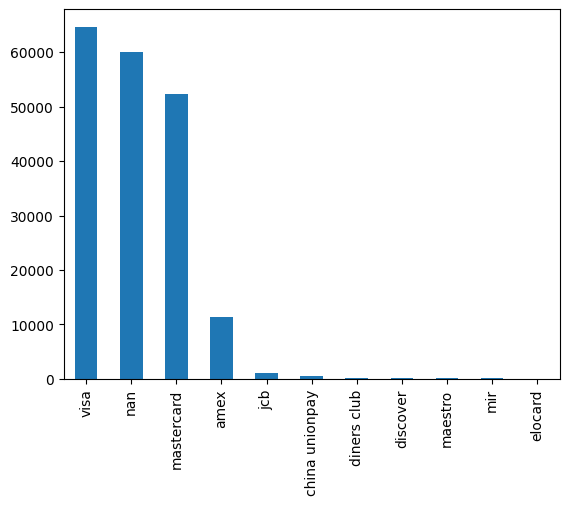

In [47]:
data.bin_brand.value_counts(dropna=False).plot(kind='bar');

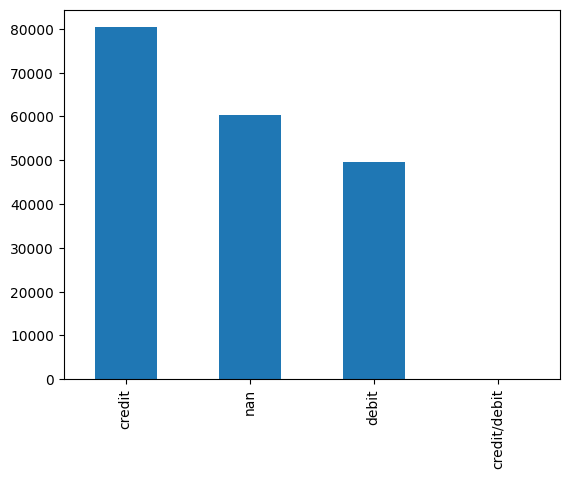

In [48]:
data.bin_type.value_counts(dropna=False).plot(kind='bar');

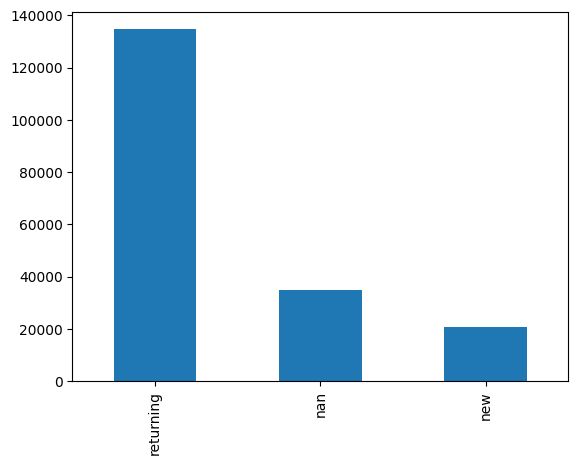

In [49]:
data.session_visitor_type.value_counts(dropna=False).plot(kind='bar');

# Test model

In [51]:
columns_to_keep = ['amount_usd','email_amount_spent_avg_180d',
                   'email_orders_count_180d', 'suspicious_activity_score',
                   'payment_method', 'avs_code',
                   'bin_brand' , 'bin_type',
                   'session_visitor_type']

In [52]:
data.dropna(subset = ['label'],inplace=True)


/var/folders/zy/9r4gn9b574gdnv2l9zms0bz40000gn/T/ipykernel_35549/2831706733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset = ['label'],inplace=True)


In [53]:
#X = data[columns_to_keep]
#y = data['label']

In [54]:
y.value_counts(dropna=False)

0.0    172802
1.0     17541
Name: label, dtype: int64

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [56]:
num_cols = ['amount_usd',
'email_amount_spent_avg_180d',
'email_orders_count_180d',
'suspicious_activity_score']

cat_cols = ['payment_method', 'avs_code',
            'bin_brand' , 'bin_type',
            'session_visitor_type']

In [68]:
# Scale then numerical values:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute with media
    ('Robust_scaler', RobustScaler())
])

# Encode categorical values
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OHE', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

# Define column transformer
# Parallelize "num_transformer" and "cat_transfomer"
preprocessor = ColumnTransformer(
    transformers = [
        ('cat_transformer', cat_transformer, cat_cols),
        ('num_transformer', num_transformer, num_cols)
    ]
)

In [69]:
model_rf = RandomForestClassifier(n_estimators=100,
                                  max_depth=5,
                                  min_samples_leaf=5,
                                  class_weight='balanced')


In [70]:
# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model_rf)])


In [71]:
X_train.shape, y_train.shape

((133240, 9), (133240,))

In [72]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['payment_method', 'avs_code',
                                                   'bin_brand', 'bin_type',
                                                   'session_visitor_type']),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Robust_scaler',
                                                                   RobustScaler())]),
                                                  ['amount_usd',
                                                   'email_amount_spent_avg_180d',
                                                   'email_orders_count_180d',
                                                   'suspicious_activity_score'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=5))])

# Cross val

In [73]:
#cv_results = cross_validate(pipeline, X_train, y_train, scoring = ['roc_auc'], cv=5)
#['accuracy', 'f1', 'roc_auc','recall','precision', 'f1_macro']

In [75]:
#cv_results
#for i in cv_results:
#    print(f' {i}: {cv_results[i].mean()}')

 fit_time: 13.91954231262207
 score_time: 0.49178643226623536
 test_roc_auc: 1.0


In [76]:
#X_train_proc = pd.DataFrame(preprocessor.fit_transform(X_train),
#            columns=preprocessor.get_feature_names_out())
#

In [122]:
#cv_results = cross_validate(model_rf, X_train_proc, y_train, scoring = ['accuracy', 'f1', 'roc_auc','recall','precision'], cv=5)


In [123]:

cv_results
for i in cv_results:
    print(f' {i}: {cv_results[i].mean()}')


 fit_time: 51.463960027694704
 score_time: 3.719663619995117
 test_roc_auc: 0.9999978320231359


In [124]:
#model_rf.fit(X_train_proc,y_train)

In [125]:
#model_rf.score(preprocessor.transform(X_test), y_test)

In [126]:
#y_pred = model_rf.predict(preprocessor.transform(X_test))


In [183]:
y_test.shape, y_pred.shape

((57103,), (57103,))

In [185]:
correct_predictions = (y_pred == y_test).sum()
print(f"Number of correct predictions: {correct_predictions} \n Percentage: {correct_predictions/y_test.shape[0]}")


Number of correct predictions: 41135 
 Percentage: 0.7203649545558026


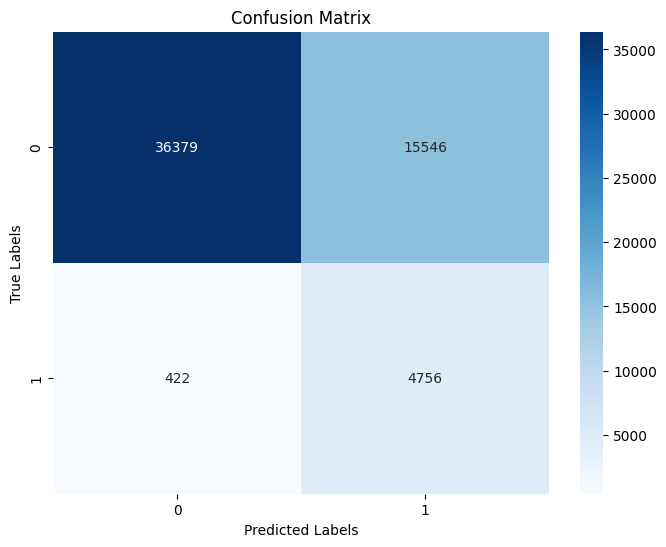

In [186]:
cm = confusion_matrix(y_test, y_pred)

# Plotting using seaborn for better aesthetics
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [187]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82     51925
         1.0       0.23      0.92      0.37      5178

    accuracy                           0.72     57103
   macro avg       0.61      0.81      0.60     57103
weighted avg       0.92      0.72      0.78     57103



In [188]:
TN, FP, FN, TP = cm.ravel()

percentage_correct_0 = TN / (TN + FP) * 100
percentage_correct_1 = TP / (TP + FN) * 100

print(f"Percentage of correct predictions for label 0: {percentage_correct_0:.2f}%")
print(f"Percentage of correct predictions for label 1: {percentage_correct_1:.2f}%")


Percentage of correct predictions for label 0: 70.06%
Percentage of correct predictions for label 1: 91.85%


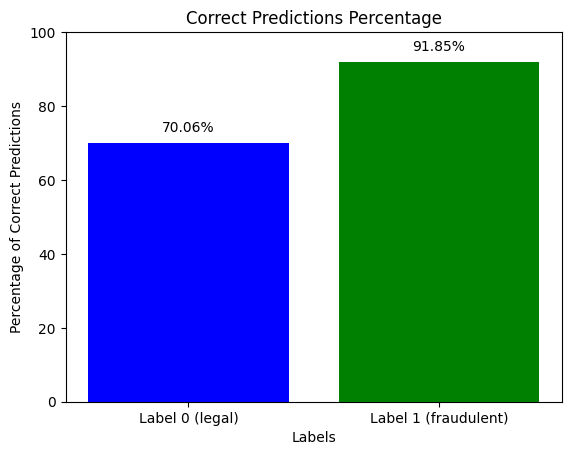

In [189]:
labels = ['Label 0 (legal)', 'Label 1 (fraudulent)']
percentages = [percentage_correct_0, percentage_correct_1]

plt.bar(labels, percentages, color=['blue', 'green'])
plt.xlabel('Labels')
plt.ylabel('Percentage of Correct Predictions')
plt.title('Correct Predictions Percentage')
plt.ylim(0, 100)  # Optional: set the y-axis to range from 0 to 100
for i, v in enumerate(percentages):
    plt.text(i, v + 3, f"{v:.2f}%", ha='center')  # Add text for each bar
plt.show()

# Testing usinf test.csv

In [ ]:
!ls data

sample_submission.csv test.csv              train.csv


In [190]:
data_test = pd.read_csv('data/test.csv').set_index("order_id")

In [191]:
data_test.head()

,order_date,amount_usd,payment_method,billing_address_country_code,shipping_address_country_code,avs_code,email_amount_spent_avg_180d,email_orders_count_180d,session_visitor_type,shipping_method_type,card_expiration_date,bin_brand,bin_type,suspicious_activity_score
order_id,,,,,,,,,,,,,,
191025041,2022-08-02 18:32:51,121.90,payment_method_1,GB,GB,avs_code_1,NaN,NaN,returning,S,NaN,NaN,NaN,0
191796174,2022-08-16 14:00:44,98.74,payment_method_1,GB,GB,avs_code_1,NaN,NaN,new,S,NaN,NaN,NaN,0
202905772,2022-11-22 02:49:31,117.03,payment_method_2,MX,MX,avs_code_3,NaN,NaN,returning,E,09/2026,mastercard,credit,0
204355210,2022-11-25 09:49:33,629.51,payment_method_1,GB,GB,avs_code_1,NaN,NaN,returning,S,NaN,NaN,NaN,0
190036435,2022-08-01 14:21:45,427.32,payment_method_2,BE,BE,avs_code_3,NaN,NaN,returning,S,05/2027,visa,debit,0


In [192]:
data_test.columns

Index(['order_date', 'amount_usd', 'payment_method',
       'billing_address_country_code', 'shipping_address_country_code',
       'avs_code', 'email_amount_spent_avg_180d', 'email_orders_count_180d',
       'session_visitor_type', 'shipping_method_type', 'card_expiration_date',
       'bin_brand', 'bin_type', 'suspicious_activity_score'],
      dtype='object')

In [193]:
rows_with_nan = data_test[data_test.isna().any(axis=1)]
num_rows_with_nan = len(rows_with_nan)
print("Number of rows with NaN in any columns:", num_rows_with_nan)
print("Number of rows total:", data_test.shape[0])

Number of rows with NaN in any columns: 42024
Number of rows total: 58216


In [138]:
pipeline

Pipeline(steps=[('remove_duplicates', Duplicates()),
                ('new_column_same_country', SameCountry()),
                ('new_column_AvgAmountSpentPerOrder180d',
                 AvgAmountSpentPerOrder180d()),
                ('new_column_time_transformed', DateTime()),
                ('new_column_shippingMethod', shippingMethodType()),
                ('Payment_Method_Transformed', PaymentMethod()),
                ('preprocessor',
                 ColumnTransformer(transformer...
                                                  Pipeline(steps=[('fillna',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['amount_usd',
                                                   'email_amount_spent_avg_180d',
                                                   'email_orders_count_180d',
                                                   'avg_amount_spent_per_order_180d',
                                                   'time_transformed',
                                                   'n_order_items',
                                                   'suspicious_activity_score'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=5))])

In [194]:
y_test_data = pipeline.predict(data_test)

In [136]:
#y_pred_test_data = model_rf.predict(data_test)

/Users/Carmen/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: '2022-08-02 18:32:51'

In [142]:
y_test_data

array([0., 0., 0., ..., 0., 0., 0.])

In [195]:
unique, counts = np.unique(y_test_data, return_counts=True)

In [196]:
unique, counts

(array([0., 1.]), array([37701, 20515]))

In [197]:
np.unique(y_test_data)

array([0., 1.])

In [198]:
y_test_data

array([0., 0., 1., ..., 1., 1., 1.])

In [199]:
len(y_test_data), data_test.shape

(58216, (58216, 14))

In [200]:
series_data = pd.Series(y_test_data)

In [201]:
series_data

0        0.0
1        0.0
2        1.0
3        0.0
4        1.0
        ... 
58211    1.0
58212    1.0
58213    1.0
58214    1.0
58215    1.0
Length: 58216, dtype: float64

In [202]:
data_test.index

Int64Index([191025041, 191796174, 202905772, 204355210, 190036435, 204286109,
            205136686, 198416671, 200845417, 200770171,
            ...
            153629784, 150192184, 188715309, 197006120, 176424602, 179298794,
            177741593, 171698657, 160426868, 172447939],
           dtype='int64', name='order_id', length=58216)

In [203]:
# Method 2: Using pd.DataFrame constructor
df_concatenated_2 = pd.DataFrame({'id': data_test.index, 'result': series_data})


In [204]:
df_concatenated_2

,id,result
0,191025041,0.0
1,191796174,0.0
2,202905772,1.0
3,204355210,0.0
4,190036435,1.0
...,...,...
58211,179298794,1.0
58212,177741593,1.0
58213,171698657,1.0
58214,160426868,1.0


In [205]:
df_concatenated_2.to_csv('baseline_results2.csv', index = False)

In [206]:
!ls

HCKTON1 copy.ipynb    README.md             baseline_results2.csv
HCKTON1.ipynb         baseline_results.csv  data
